# Prediction of Daily Bike Rental Ridership

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)
print(rides.head())
print(rides.shape)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  
(17379, 17)


# Data Explanation

- There are 17379 records and 17 features
- Dataset illustrates number of riders for each hour of each day frome Jan 2011-Dec 2012.
- Number of riders = cnt (on the dataset) = casual + registered.
- Number of riders of first 10 days of the dataset shown below 24hrs*10days.

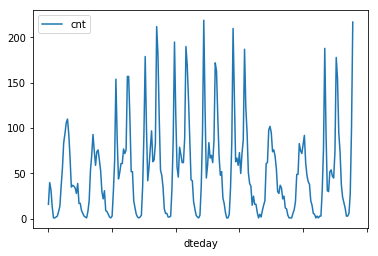

In [2]:
rides[:24*10].plot(x='dteday', y='cnt')

# Dummy variables
- We have to change categorical variables like season, weather, month into binary dummy variables with help of pandas library using get_dummies() function. 


In [3]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr', 'casual', 'registered']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,16,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,40,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,32,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,13,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Normalize target variables
- Make the mean 0 and standard deviation 1.

In [4]:
quant_features = ['cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

# Split data into TRAINING, TESTING, and VALIDATION sets
- data of last 21 days will be testing data

In [5]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt']#, 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
X_test, Y_test = test_data.drop(target_fields, axis=1), test_data[target_fields]
print(features.shape)
print(targets.shape)
print("Test Features: ",X_test.shape)
print("Test Targets: ",Y_test.shape)

(16875, 56)
(16875, 1)
Test Features:  (504, 56)
Test Targets:  (504, 1)


- rest of the data will be splitted into TRAINING AND VALIDATION sets.

In [6]:
# Hold out the last 60 days or so of the remaining data as a validation set
X_train, Y_train = features[:-60*24], targets[:-60*24]
X_valid, Y_valid = features[-60*24:], targets[-60*24:]
print("Train Data: ",X_train.shape)
print("Validation Data: ", X_valid.shape)

Train Data:  (15435, 56)
Validation Data:  (1440, 56)


In [7]:
n_features = 56

X = tf.placeholder(tf.float32, (None, n_features))
Y_real = tf.placeholder(tf.float32, (None,1))

tf.set_random_seed(1)

W1 = tf.get_variable("W1",[n_features,20],initializer = tf.contrib.layers.xavier_initializer(seed=1))
b1 = tf.get_variable("b1",[20],initializer = tf.zeros_initializer())
W2 = tf.get_variable("W2",[20,1],initializer = tf.contrib.layers.xavier_initializer(seed=1))
b2 = tf.get_variable("b2",[1],initializer = tf.zeros_initializer())

Z1 = tf.matmul(X,W1) + b1
A1 = tf.nn.sigmoid(Z1)
Z2 = tf.matmul(A1,W2) + b2
Y_pred = Z2

loss = tf.losses.mean_squared_error(labels=Y_real,predictions=Y_pred)

train_op = tf.train.AdamOptimizer(0.05).minimize(loss)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

TRAIN_STEPS = 2000
for i in range(TRAIN_STEPS):
	sess.run(train_op, feed_dict = {X: X_train, Y_real: Y_train})
	if i % 100 == 0:
		print('Train Step: ' + str(i) + " ;"
		 #+ 'Accuracy: ' + str(sess.run(accuracy, feed_dict = {X: X_test, Y_: Y_test})) + " ;"
		 + 'Loss: ' + str(sess.run(loss, feed_dict = {X: X_train, Y_real: Y_train})))






Train Step: 0 ;Loss: 1.2227665
Train Step: 100 ;Loss: 0.1879399
Train Step: 200 ;Loss: 0.05845969
Train Step: 300 ;Loss: 0.048491806
Train Step: 400 ;Loss: 0.04321753
Train Step: 500 ;Loss: 0.04012005
Train Step: 600 ;Loss: 0.038378652
Train Step: 700 ;Loss: 0.03770818
Train Step: 800 ;Loss: 0.03648311
Train Step: 900 ;Loss: 0.035881005
Train Step: 1000 ;Loss: 0.035175566
Train Step: 1100 ;Loss: 0.034810763
Train Step: 1200 ;Loss: 0.034491796
Train Step: 1300 ;Loss: 0.034350246
Train Step: 1400 ;Loss: 0.03416638
Train Step: 1500 ;Loss: 0.048057426
Train Step: 1600 ;Loss: 0.033969402
Train Step: 1700 ;Loss: 0.03385539
Train Step: 1800 ;Loss: 0.035765573
Train Step: 1900 ;Loss: 0.03373434


In [8]:

s = Y_pred.eval(feed_dict={X: X_test}, session=sess)
#print(prediction.eval(feed_dict={X: X_test}, session=sess))
#sess.close()

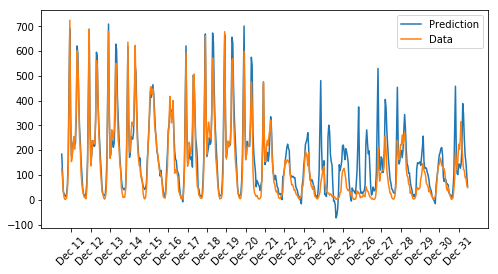

In [17]:

fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
#predictions = network.run(test_features).T*std + mean
ax.plot(s*std+mean, label='Prediction')
ax.plot((Y_test['cnt']*std + mean).values, label='Data')
#ax.set_xlim(right=len(predictions))
ax.legend()
#ax.ylabel('count')

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)